In [10]:
import pandas as pd

pd.read_csv("merged_char_dataset.csv")

,Unnamed: 0.1,Unnamed: 0,jp_title,en_title,char_name,fav,img
0,0,0,Shingeki no Kyojin: The Final Season,Attack on Titan: Final Season,Eren Yeager (エレン・イェーガー),"Member Favorites: 71,891",https://cdn.myanimelist.net/images/characters/...
1,1,1,Shingeki no Kyojin: The Final Season,Attack on Titan: Final Season,Mikasa Ackerman (ミカサ・アッカーマン),"Member Favorites: 55,501",https://cdn.myanimelist.net/images/characters/...
2,2,2,Shingeki no Kyojin: The Final Season,Attack on Titan: Final Season,Armin Arlert (アルミン・アルレルト),"Member Favorites: 20,861",https://cdn.myanimelist.net/images/characters/...
3,3,3,Shingeki no Kyojin: The Final Season,Attack on Titan: Final Season,Levi (リヴァイ),"Member Favorites: 142,823",https://cdn.myanimelist.net/images/characters/...
4,4,4,Shingeki no Kyojin: The Final Season,Attack on Titan: Final Season,Hange Zoë (ハンジ・ゾエ),"Member Favorites: 19,971",https://cdn.myanimelist.net/images/characters/...
...,...,...,...,...,...,...,...
10946,10946,808,Jochum,NaN,Ruru,Member Favorites: 0,https://cdn.myanimelist.net/images/characters/...
10947,10947,809,Jochum,NaN,Bira,Member Favorites: 0,https://cdn.myanimelist.net/images/characters/...
10948,10948,810,Jochum,NaN,Moco (もこ),Member Favorites: 0,https://cdn.myanimelist.net/images/characters/...
10949,10949,811,Jochum,NaN,Chulala (チュララ),Member Favorites: 0,https://cdn.myanimelist.net/images/characters/...


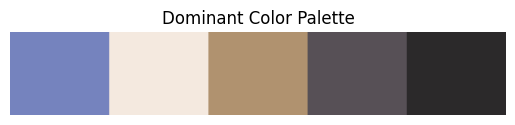

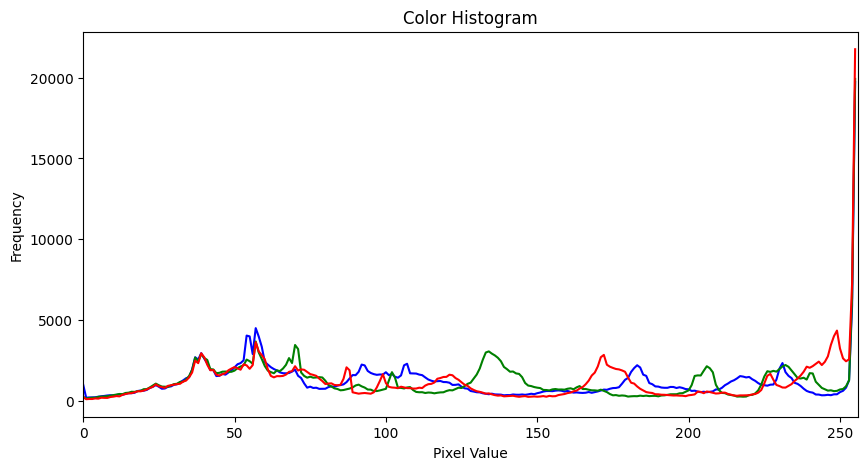

Extracted Color Features:
-------------------------
Dominant Colors (BGR):
[[190 131 117]
 [223 233 244]
 [111 146 176]
 [ 86  80  87]
 [ 42  41  43]]

RMS Contrast (std. dev. of L channel): 77.85221690040252


In [9]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def extract_color_palette(image, num_clusters=5):
    """
    Extracts the dominant color palette from an image using K-Means clustering.
    
    Args:
        image: Input image in BGR format.
        num_clusters: Number of dominant colors to extract.
    
    Returns:
        dominant_colors: An array of dominant colors (in BGR).
    """
    # Convert image from BGR to RGB for clustering
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Reshape the image to be a list of pixels
    pixels = image_rgb.reshape((-1, 3))
    
    # Run K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(pixels)
    dominant_colors = np.array(kmeans.cluster_centers_, dtype="uint8")
    
    # Convert dominant colors back to BGR for consistency with OpenCV if needed
    dominant_colors = cv2.cvtColor(dominant_colors.reshape(1, -1, 3), cv2.COLOR_RGB2BGR).reshape(-1, 3)
    return dominant_colors

def compute_contrast(image):
    """
    Computes a contrast measure for the image based on the standard deviation
    of the luminance channel in LAB color space.
    
    Args:
        image: Input image in BGR format.
    
    Returns:
        rms_contrast: The root-mean-square contrast (standard deviation of L channel).
    """
    # Convert the image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # The L channel represents lightness
    L_channel = lab[:, :, 0]
    # Compute the standard deviation of the L channel as a measure of contrast
    rms_contrast = np.std(L_channel)
    return rms_contrast

def compute_color_histogram(image, bins=256):
    """
    Computes the color histogram for each channel (B, G, R) of the image.
    
    Args:
        image: Input image in BGR format.
        bins: Number of bins for the histogram.
    
    Returns:
        hist_data: Dictionary with histograms for 'b', 'g', and 'r' channels.
    """
    color = ('b', 'g', 'r')
    hist_data = {}
    for i, col in enumerate(color):
        hist = cv2.calcHist([image], [i], None, [bins], [0, 256])
        hist_data[col] = hist.flatten()
    return hist_data

def plot_color_histogram(hist_data):
    """
    Plots the color histogram for each channel.
    
    Args:
        hist_data: Dictionary containing histograms for 'b', 'g', and 'r'.
    """
    plt.figure(figsize=(10, 5))
    for col in hist_data:
        plt.plot(hist_data[col], color=col)
        plt.xlim([0, 256])
    plt.title("Color Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()

def show_palette(palette):
    """
    Displays the dominant color palette as color patches.
    
    Args:
        palette: Array of dominant colors (in BGR format).
    """
    patch = np.zeros((50, 300, 3), dtype="uint8")
    num_colors = palette.shape[0]
    patch_width = patch.shape[1] // num_colors
    for i, color in enumerate(palette):
        patch[:, i * patch_width:(i + 1) * patch_width] = color
    # Convert from BGR to RGB for displaying with matplotlib
    patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    plt.imshow(patch_rgb)
    plt.title("Dominant Color Palette")
    plt.axis("off")
    plt.show()

def main(image_path):
    # Read the input image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read the image.")
        return

    # Extract dominant color palette
    palette = extract_color_palette(image, num_clusters=5)
    
    # Compute contrast measure
    contrast = compute_contrast(image)
    
    # Compute color histograms
    hist_data = compute_color_histogram(image)
    
    # Display the palette and histogram
    show_palette(palette)
    plot_color_histogram(hist_data)
    
    print("Extracted Color Features:")
    print("-------------------------")
    print("Dominant Colors (BGR):")
    print(palette)
    print("\nRMS Contrast (std. dev. of L channel):", contrast)

if __name__ == "__main__":
    image_path = "Test_img/test_img2.jpg"  # Replace with your image file path
    main(image_path)


In [8]:
import cv2
import numpy as np

img = cv2.imread("Test_img/test_img.jpg")

img_resized = cv2.resize(img, (256, 256))

img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

img_nomalized = img_gray / 255.0

edges = cv2.Canny(img_gray, threshold1=100, threshold2=200)

cv2.imshow("Edges", edges)

cv2.waitKey(0)
cv2.destroyAllWindows()

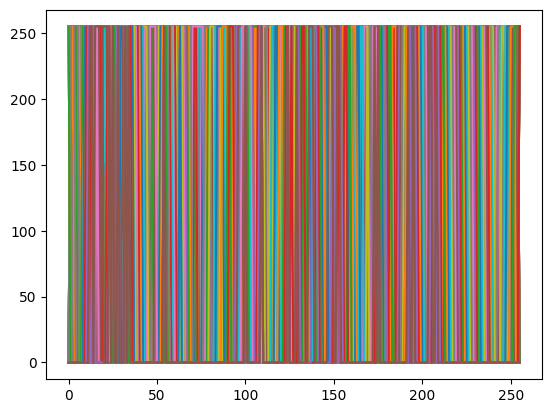

In [4]:
import matplotlib.pyplot as plt

plt.plot(edges)
plt.show()

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib
from sklearn.cluster import KMeans
import mediapipe as mp
import json
import os

# ----- 1. Preprocessing -----
def preprocess_image(image_path, target_size=(256, 256)):
    """
    Reads an image, resizes it to target_size, converts to grayscale,
    and normalizes pixel values.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Unable to read image at {image_path}")
    # Resize image
    image_resized = cv2.resize(image, target_size)
    # Convert to grayscale
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    # Normalize (0-1)
    image_normalized = image_gray / 255.0
    return image_resized, image_gray, image_normalized

# ----- 2A. Edge Detection for Linework Analysis -----
def extract_edges(image_gray, threshold1=100, threshold2=200):
    """
    Applies the Canny edge detector on a grayscale image.
    Returns the edge image and the mean edge density.
    """
    edges = cv2.Canny(image_gray, threshold1, threshold2)
    # Compute edge density as the mean of edge values (0 or 255 normalized)
    edge_density = np.mean(edges / 255.0)
    return edges, edge_density

# ----- 2B. Color Palette Extraction using K-Means -----
def extract_color_palette(image, num_clusters=5):
    """
    Reshapes the image pixels and applies K-Means clustering to find dominant colors.
    Returns the dominant colors.
    """
    # Convert image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Reshape image to a list of pixels
    pixels = image_rgb.reshape((-1, 3))
    # Run KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(pixels)
    dominant_colors = np.array(kmeans.cluster_centers_, dtype='uint8')
    return dominant_colors

# ----- 2C. Facial Landmark Analysis using dlib -----
def extract_facial_landmarks(image_gray, image_color, predictor_path="shape_predictor_68_face_landmarks.dat"):
    """
    Detects faces and facial landmarks.
    Returns the image with landmarks drawn and computes a sample eye size ratio.
    """
    detector = dlib.get_frontal_face_detector()
    
    if not os.path.exists(predictor_path):
        print("Dlib landmark predictor not found. Skipping facial landmark extraction.")
        return image_color, None

    predictor = dlib.shape_predictor(predictor_path)
    faces = detector(image_gray)
    
    # For demonstration, we calculate a simple "eye size ratio" for the first detected face.
    eye_size_ratio = None
    for face in faces:
        landmarks = predictor(image_gray, face)
        # Draw landmarks
        for n in range(68):
            x, y = landmarks.part(n).x, landmarks.part(n).y
            cv2.circle(image_color, (x, y), 2, (0, 255, 0), -1)
        
        # Example: calculate left eye height using landmarks 37 and 41 (upper and lower points)
        # Note: dlib landmarks for left eye: 36-41 (0-indexed 36 to 41)
        left_eye_top = landmarks.part(37).y
        left_eye_bottom = landmarks.part(41).y
        eye_height = abs(left_eye_bottom - left_eye_top)
        # Approximate face width from detected face rectangle
        face_width = face.right() - face.left()
        eye_size_ratio = eye_height / face_width if face_width != 0 else 0
        break  # Only processing the first face
    return image_color, eye_size_ratio

# ----- 2D. Pose Estimation using MediaPipe -----
def extract_pose_estimation(image, target_size=(256, 256)):
    """
    Uses MediaPipe to detect pose landmarks.
    Returns the image with pose landmarks drawn and computes a sample head-to-body ratio.
    For demonstration, we compute ratio as the distance from the nose tip to mid-shoulder / image height.
    """
    # Initialize MediaPipe pose
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    
    head_body_ratio = None
    if results.pose_landmarks:
        # Draw pose landmarks on the image
        mp_drawing = mp.solutions.drawing_utils
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
        # Extract specific landmarks: nose (landmark 0) and shoulders (landmarks 11 and 12)
        landmark_points = results.pose_landmarks.landmark
        nose = landmark_points[0]
        left_shoulder = landmark_points[11]
        right_shoulder = landmark_points[12]
        
        # Convert normalized coordinates to pixel values
        h, w, _ = image.shape
        nose_y = nose.y * h
        left_shoulder_y = left_shoulder.y * h
        right_shoulder_y = right_shoulder.y * h
        mid_shoulder_y = (left_shoulder_y + right_shoulder_y) / 2
        
        # Head-to-body ratio (using vertical distance from nose to mid-shoulder normalized by image height)
        head_body_ratio = abs(mid_shoulder_y - nose_y) / h
    else:
        print("No pose landmarks detected.")
    
    pose.close()
    return image, head_body_ratio

# ----- 3. Main Function to Process an Image and Save Features -----
def process_anime_image(image_path):
    # Preprocess image
    image_color, image_gray, image_normalized = preprocess_image(image_path)

    # Extract edge information
    edges, edge_density = extract_edges(image_gray)
    
    # Extract dominant colors from the color image
    dominant_colors = extract_color_palette(image_color, num_clusters=5)
    
    # Perform facial landmark analysis
    image_with_landmarks, eye_size_ratio = extract_facial_landmarks(image_gray.copy(), image_color.copy())
    
    # Perform pose estimation
    image_with_pose, head_body_ratio = extract_pose_estimation(image_color.copy())

    # Combine extracted features into a dictionary
    features = {
        "edge_density": edge_density,
        "dominant_colors": dominant_colors.tolist(),  # Convert numpy array to list
        "eye_size_ratio": eye_size_ratio,
        "head_body_ratio": head_body_ratio
    }
    
    # Save features to a JSON file
    features_filename = os.path.splitext(os.path.basename(image_path))[0] + "_features.json"
    with open(features_filename, "w") as f:
        json.dump(features, f, indent=4)
    print(f"Features saved to {features_filename}")
    
    # Display intermediate outputs for verification
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
    plt.title("Original Color Image")
    plt.axis("off")
    
    plt.subplot(2, 3, 2)
    plt.imshow(image_gray, cmap="gray")
    plt.title("Grayscale Image")
    plt.axis("off")
    
    plt.subplot(2, 3, 3)
    plt.imshow(edges, cmap="gray")
    plt.title("Canny Edges")
    plt.axis("off")
    
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(image_with_landmarks, cv2.COLOR_BGR2RGB))
    plt.title("Facial Landmarks")
    plt.axis("off")
    
    plt.subplot(2, 3, 5)
    plt.imshow(cv2.cvtColor(image_with_pose, cv2.COLOR_BGR2RGB))
    plt.title("Pose Landmarks")
    plt.axis("off")
    
    # Show dominant colors as color patches
    plt.subplot(2, 3, 6)
    patch = np.zeros((50, 300, 3), dtype="uint8")
    num_colors = dominant_colors.shape[0]
    patch_width = patch.shape[1] // num_colors
    for i, color in enumerate(dominant_colors):
        patch[:, i * patch_width:(i + 1) * patch_width] = color
    plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
    plt.title("Dominant Colors")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return features

# ----- 4. Run the Processing on an Example Image -----
if __name__ == "__main__":
    image_file = "Test_img/test_img2.jpg"  # Replace with your image file path
    try:
        extracted_features = process_anime_image(image_file)
        print("Extracted Features:")
        print(json.dumps(extracted_features, indent=4))
    except Exception as e:
        print(f"An error occurred: {e}")


ModuleNotFoundError: No module named 'dlib'

In [3]:
import pandas as pd

# df_title = pd.read_csv("AnimeDataset/merged_anime_dataset.csv")
df_title = pd.read_csv("filtered_title.csv", delimiter=";")
filtered_title = df_title["jp_title"].unique()

df_chacter = pd.read_csv("CharacterDataset/merged_char_dataset.csv")
df_chacter.head()

,test,Unnamed: 0,jp_title,en_title,char_name,fav,img
0,0,0,Shingeki no Kyojin: The Final Season,Attack on Titan: Final Season,Eren Yeager (エレン・イェーガー),"Member Favorites: 71,891",https://cdn.myanimelist.net/images/characters/...
1,1,1,Shingeki no Kyojin: The Final Season,Attack on Titan: Final Season,Mikasa Ackerman (ミカサ・アッカーマン),"Member Favorites: 55,501",https://cdn.myanimelist.net/images/characters/...
2,2,2,Shingeki no Kyojin: The Final Season,Attack on Titan: Final Season,Armin Arlert (アルミン・アルレルト),"Member Favorites: 20,861",https://cdn.myanimelist.net/images/characters/...
3,3,3,Shingeki no Kyojin: The Final Season,Attack on Titan: Final Season,Levi (リヴァイ),"Member Favorites: 142,823",https://cdn.myanimelist.net/images/characters/...
4,4,4,Shingeki no Kyojin: The Final Season,Attack on Titan: Final Season,Hange Zoë (ハンジ・ゾエ),"Member Favorites: 19,971",https://cdn.myanimelist.net/images/characters/...


In [5]:
import pandas as pd

from colorPallete import ColorPaletteExtractor

extractor = ColorPaletteExtractor

df = pd.read_csv("char_color_palette.csv")

df.iloc[0,8]


'[[8, 16, 10], [176, 193, 199], [48, 72, 60], [89, 147, 186], [250, 253, 253], [163, 217, 252], [74, 111, 146], [76, 98, 96], [22, 41, 50], [141, 159, 150]]'

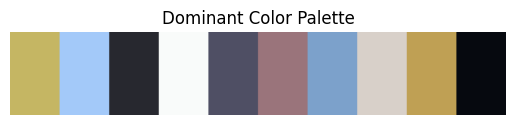

Palette (BGR format):
[[ 99 182 197]
 [249 201 163]
 [ 47  40  39]
 [250 251 249]
 [100  79  79]
 [123 116 154]
 [203 161 124]
 [201 208 216]
 [ 84 160 191]
 [ 15   9   6]]


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class ColorPaletteExtractor:
    def __init__(self):
        self.image = None
        self.palette = None

    def display_palette(self):
        """Display the extracted color palette."""
        if self.palette is None:
            raise RuntimeError("No palette extracted. Extract palette first.")
        
        # Create visualization
        patch = np.zeros((50, 300, 3), dtype=np.uint8)
        num_colors = len(self.palette)
        patch_width = 300 // num_colors
        
        for i, color in enumerate(self.palette):
            start_col = i * patch_width
            end_col = (i + 1) * patch_width
            patch[:, start_col:end_col] = color
        
        # Convert and display
        patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
        plt.imshow(patch_rgb)
        plt.title("Dominant Color Palette")
        plt.axis("off")
        plt.show()

    def get_palette(self):
        """Return the extracted color palette."""
        return self.palette.copy() if self.palette is not None else None

if __name__ == "__main__":
    extractor = ColorPaletteExtractor()
    try:
        color_str = df.iloc[423,8]
        rgb_palette = eval(color_str)
        # Convert each color from RGB to BGR (reverse the order)
        bgr_palette = np.array([[color[2], color[1], color[0]] for color in rgb_palette], dtype=np.uint8)
        extractor.palette = bgr_palette
        
        extractor.display_palette()
        print("Palette (BGR format):")
        print(extractor.get_palette())
    except Exception as e:
        print(f"Error: {str(e)}")